<a href="https://colab.research.google.com/github/BelenGutierrezG/GLAB11_MDD_AG/blob/develop/lab11_MDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import polars as pl
from scipy.stats import chi2

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
print(f"ALGORITMOS GENÉTICOS Y EVOLUCIÓN DE LA POBLACIÓN")
print(f"LABORATORIO 11")
print(f"Estudiante")
print(f"- Gutierrez Garcia, Angela Belen / - Hinostroza Martinez, Bryan")

print(f"\n{'='*50}\n{'='*50}\n")
print(f"a. Realice el preprocesamiento de la información que incluya el análisis de datos faltantes,tratamiento de outliers a nivel univariado y multivariado y escalamiento de datos para las variables numéricas.\n")

# Carga del archivo desde Google Drive
url = "https://raw.githubusercontent.com/BelenGutierrezG/LAB11_AG/refs/heads/main/Advertising-1.csv"

df = pl.read_csv(url)
print("Dataset cargado:")
print(df.head())


ALGORITMOS GENÉTICOS Y EVOLUCIÓN DE LA POBLACIÓN
LABORATORIO 11
Estudiante
- Gutierrez Garcia, Angela Belen


a. Realice el preprocesamiento de la información que incluya el análisis de datos faltantes,tratamiento de outliers a nivel univariado y multivariado y escalamiento de datos para las variables numéricas.

Dataset cargado:
shape: (5, 4)
┌───────┬───────┬───────────┬───────┐
│ TV    ┆ Radio ┆ Newspaper ┆ Sales │
│ ---   ┆ ---   ┆ ---       ┆ ---   │
│ f64   ┆ f64   ┆ f64       ┆ f64   │
╞═══════╪═══════╪═══════════╪═══════╡
│ 230.1 ┆ 37.8  ┆ 69.2      ┆ 22.1  │
│ 44.5  ┆ 39.3  ┆ 45.1      ┆ 10.4  │
│ 17.2  ┆ 45.9  ┆ 69.3      ┆ 9.3   │
│ 151.5 ┆ 41.3  ┆ 58.5      ┆ 18.5  │
│ 180.8 ┆ 10.8  ┆ 58.4      ┆ 12.9  │
└───────┴───────┴───────────┴───────┘


In [ ]:
print("\n" + "="*50)
print("Análisis de datos faltantes:")
nulos = df.null_count()
print(nulos)
print("- No existe ningún dato faltante en ninguna variable\n")


Análisis de datos faltantes:
shape: (1, 4)
┌─────┬───────┬───────────┬───────┐
│ TV  ┆ Radio ┆ Newspaper ┆ Sales │
│ --- ┆ ---   ┆ ---       ┆ ---   │
│ u32 ┆ u32   ┆ u32       ┆ u32   │
╞═════╪═══════╪═══════════╪═══════╡
│ 0   ┆ 0     ┆ 0         ┆ 0     │
└─────┴───────┴───────────┴───────┘
- No existe ningún dato faltante en ninguna variable



In [ ]:
print("="*50)
print("Tratamiento de outliers univariados:\n")

factor_iqr = 1.5
mascara = pl.lit(True)

for col in df.select(pl.col(pl.NUMERIC_DTYPES)).columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    limite_inf = q1 - factor_iqr * iqr
    limite_sup = q3 + factor_iqr * iqr

    print(f"\nColumna: {col}")
    print(f"• Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}")
    print(f"• Límites: [{limite_inf:.2f}, {limite_sup:.2f}]")

    mascara_col = (pl.col(col) >= limite_inf) & (pl.col(col) <= limite_sup)
    mascara = mascara & mascara_col

    outliers = df.filter(~mascara_col)
    print(f"• Outliers detectados: {outliers.height} fila(s)")

df1 = df.filter(mascara)
print(f"\nFilas eliminadas: {df.height - df1.height}\n")

Tratamiento de outliers univariados:


Columna: TV
• Q1: 74.70, Q3: 218.50, IQR: 143.80
• Límites: [-141.00, 434.20]
• Outliers detectados: 0 fila(s)

Columna: Radio
• Q1: 10.00, Q3: 36.50, IQR: 26.50
• Límites: [-29.75, 76.25]
• Outliers detectados: 0 fila(s)

Columna: Newspaper
• Q1: 12.80, Q3: 45.10, IQR: 32.30
• Límites: [-35.65, 93.55]
• Outliers detectados: 2 fila(s)

Columna: Sales
• Q1: 10.40, Q3: 17.40, IQR: 7.00
• Límites: [-0.10, 27.90]
• Outliers detectados: 0 fila(s)

Filas eliminadas: 2



C:\Users\Belen\AppData\Local\Temp\ipykernel_26392\1530119546.py:7: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  for col in df.select(pl.col(pl.NUMERIC_DTYPES)).columns:


In [ ]:
print("Outliers multivariados:\n")

n_col = df1.select(pl.col(pl.NUMERIC_DTYPES)).columns
data = df1.select(pl.col(n_col)).to_numpy()

cov_matrix = np.cov(data, rowvar=False)
try:
    inv_cov_matrix = np.linalg.inv(cov_matrix)
except np.linalg.LinAlgError:
    inv_cov_matrix = np.linalg.pinv(cov_matrix)

mean_vec = np.mean(data, axis=0)
diff = data - mean_vec
mahalanobis_dist = np.array([np.sqrt(d.dot(inv_cov_matrix).dot(d)) for d in diff])

threshold = np.sqrt(chi2.ppf(0.95, df=len(n_col)))
print(f"Umbral de Mahalanobis (95% confianza): {threshold:.4f}")

es_outlier = mahalanobis_dist > threshold
outliers_count = np.sum(es_outlier)
print(f"Outliers detectados: {outliers_count}")

df1 = pl.concat([
    df1,
    pl.DataFrame({
        "mahalanobis": mahalanobis_dist.tolist(),
        "es_outlier": es_outlier.tolist()
    })
], how="horizontal")

df_clean = df1.filter(~pl.col("es_outlier"))
print(f"DataFrame limpio: {df_clean.height} filas (eliminados {outliers_count} outliers)\n")

Outliers multivariados:

Umbral de Mahalanobis (95% confianza): 3.0802
Outliers detectados: 9
DataFrame limpio: 189 filas (eliminados 9 outliers)



C:\Users\Belen\AppData\Local\Temp\ipykernel_26392\1665230047.py:3: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  n_col = df1.select(pl.col(pl.NUMERIC_DTYPES)).columns


In [ ]:
print("="*50 + "\n" + "="*50)
print("Algoritmo genético para selección de variables:\n")

X = df_clean.drop(["Sales", "mahalanobis", "es_outlier"]).to_numpy()
y = df_clean["Sales"].to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

modelo = linear_model.LinearRegression()
n_features = X_scaled.shape[1]
verbose = 0

def calculate_fitness(modelo, x, y):
    if x.shape[1] == 0:
        return 0.0
    try:
        scores = cross_val_score(modelo, x, y, cv=5, scoring='r2')
        return np.mean(scores)
    except:
        return 0.0

def evaluate(individual):
    np_ind = np.asarray(individual)
    if np.sum(np_ind) == 0:
        return (0.0,)
    feature_idx = np.where(np_ind == 1)[0]
    fitness = calculate_fitness(modelo, X_scaled[:, feature_idx], y)
    return (fitness,)

creator.create("FeatureSelect", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FeatureSelect)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

N_POP = 50
CX_PB = 0.5
MUT_PB = 0.2
N_GEN = 20

def build_stats(gen, pop, fits):
    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5
    print(f"Gen: {gen+1} | Min: {min(fits):.4f} | Max: {max(fits):.4f} | Avg: {mean:.4f} | Std: {std:.4f}")
    return {'gen': gen+1, 'min': min(fits), 'max': max(fits), 'avg': mean, 'std': std}

pop = toolbox.population(N_POP)
fitnesses = list(map(toolbox.evaluate, pop))

for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

stats_records = []
stats_records.append(build_stats(0, pop, [ind.fitness.values[0] for ind in pop]))

for g in range(N_GEN):
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CX_PB:
            toolbox.mate(child1, child2)
            del child1.fitness.values, child2.fitness.values

    for mutant in offspring:
        if random.random() < MUT_PB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = list(map(toolbox.evaluate, invalid_ind))
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    pop[:] = offspring
    stats_records.append(build_stats(g + 1, pop, [ind.fitness.values[0] for ind in pop]))

Algoritmo genético para selección de variables:

Gen: 1 | Min: 0.0000 | Max: 0.9218 | Avg: 0.4097 | Std: 0.3245
Gen: 2 | Min: 0.0000 | Max: 0.9218 | Avg: 0.6393 | Std: 0.2744
Gen: 3 | Min: 0.0000 | Max: 0.9218 | Avg: 0.8163 | Std: 0.1844
Gen: 4 | Min: 0.3998 | Max: 0.9218 | Avg: 0.9051 | Std: 0.0844
Gen: 5 | Min: 0.3998 | Max: 0.9218 | Avg: 0.9051 | Std: 0.0844
Gen: 6 | Min: 0.3998 | Max: 0.9218 | Avg: 0.9051 | Std: 0.0844
Gen: 7 | Min: 0.3998 | Max: 0.9218 | Avg: 0.9114 | Std: 0.0731
Gen: 8 | Min: 0.3998 | Max: 0.9218 | Avg: 0.8905 | Std: 0.1240
Gen: 9 | Min: 0.3998 | Max: 0.9218 | Avg: 0.9113 | Std: 0.0731
Gen: 10 | Min: 0.3998 | Max: 0.9218 | Avg: 0.9051 | Std: 0.0844
Gen: 11 | Min: 0.3998 | Max: 0.9218 | Avg: 0.9114 | Std: 0.0731
Gen: 12 | Min: 0.9218 | Max: 0.9218 | Avg: 0.9218 | Std: 0.0000
Gen: 13 | Min: 0.9218 | Max: 0.9218 | Avg: 0.9218 | Std: 0.0000
Gen: 14 | Min: 0.6547 | Max: 0.9218 | Avg: 0.9164 | Std: 0.0374
Gen: 15 | Min: 0.3998 | Max: 0.9218 | Avg: 0.8884 | Std: 0.1170


In [ ]:
best_ind = tools.selBest(pop, 1)[0]
print("Mejor individuo:", best_ind)
print("Fitness:", best_ind.fitness.values[0])

feature_names = df_clean.drop(["Sales", "mahalanobis", "es_outlier"]).columns
selected_features = np.where(np.array(best_ind) == 1)[0]
selected_feature_names = [feature_names[i] for i in selected_features]

print("Variables seleccionadas:", selected_feature_names)

X_selected = X_scaled[:, selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

modelo_final = linear_model.LinearRegression()
modelo_final.fit(X_train, y_train)

y_pred_train = modelo_final.predict(X_train)
y_pred_test = modelo_final.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"\nR² en entrenamiento: {r2_train:.4f}")
print(f"R² en prueba: {r2_test:.4f}")

Mejor individuo: [1, 1, 0]
Fitness: 0.9217977803708935
Variables seleccionadas: ['TV', 'Radio']

R² en entrenamiento: 0.9344
R² en prueba: 0.8902


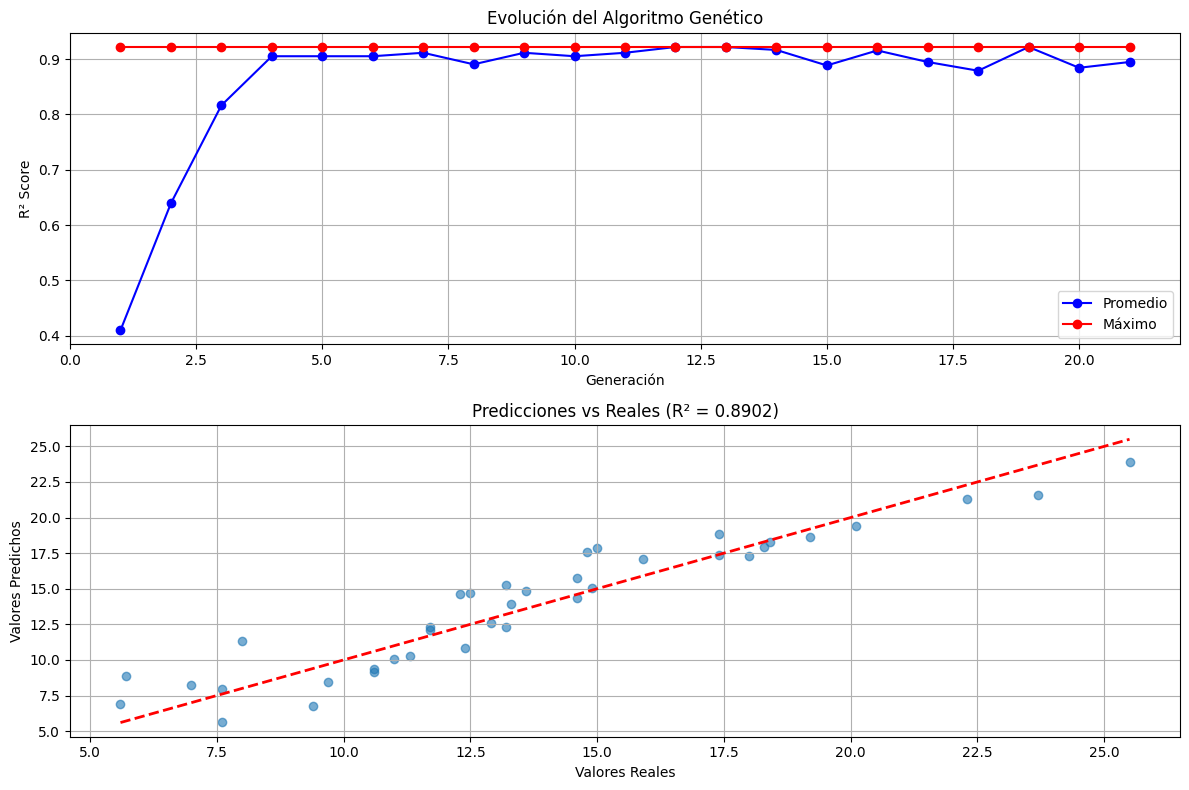

In [ ]:
generations = [record['gen'] for record in stats_records]
avg_fitness = [record['avg'] for record in stats_records]
max_fitness = [record['max'] for record in stats_records]

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(generations, avg_fitness, 'b-o', label='Promedio')
plt.plot(generations, max_fitness, 'r-o', label='Máximo')
plt.xlabel('Generación')
plt.ylabel('R² Score')
plt.title('Evolución del Algoritmo Genético')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title(f'Predicciones vs Reales (R² = {r2_test:.4f})')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
%%writefile utils.py
import numpy as np
import polars as pl
from scipy.stats import chi2
from sklearn.model_selection import cross_val_score

def eliminar_outliers_univariados(df: pl.DataFrame, factor_iqr: float = 1.5) -> pl.DataFrame:
    mascara = pl.lit(True)
    for col in df.select(pl.col(pl.NUMERIC_DTYPES)).columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        limite_inf = q1 - factor_iqr * iqr
        limite_sup = q3 + factor_iqr * iqr
        mascara_col = (pl.col(col) >= limite_inf) & (pl.col(col) <= limite_sup)
        mascara = mascara & mascara_col
    return df.filter(mascara)

def detectar_outliers_mahalanobis(df: pl.DataFrame, cols: list[str]) -> pl.DataFrame:
    data = df.select(cols).to_numpy()
    cov_matrix = np.cov(data, rowvar=False)
    try:
        inv_cov_matrix = np.linalg.inv(cov_matrix)
    except np.linalg.LinAlgError:
        inv_cov_matrix = np.linalg.pinv(cov_matrix)
    mean_vec = np.mean(data, axis=0)
    diff = data - mean_vec
    mahalanobis_dist = np.array([np.sqrt(d.dot(inv_cov_matrix).dot(d)) for d in diff])
    threshold = np.sqrt(chi2.ppf(0.95, df=len(cols)))
    es_outlier = mahalanobis_dist > threshold
    return pl.concat([
        df,
        pl.DataFrame({
            "mahalanobis": mahalanobis_dist.tolist(),
            "es_outlier": es_outlier.tolist()
        })
    ], how="horizontal")

def filtrar_outliers(df: pl.DataFrame) -> pl.DataFrame:
    return df.filter(~pl.col("es_outlier"))

def calcular_fitness(modelo, x, y):
    if x.shape[1] == 0:
        return 0.0
    try:
        scores = cross_val_score(modelo, x, y, cv=5, scoring='r2')
        return np.mean(scores)
    except:
        return 0.0

def evaluar_individuo(individual, modelo, X_scaled, y):
    np_ind = np.asarray(individual)
    if np.sum(np_ind) == 0:
        return (0.0,)
    feature_idx = np.where(np_ind == 1)[0]
    fitness = calcular_fitness(modelo, X_scaled[:, feature_idx], y)
    return (fitness,)

Writing utils.py


In [ ]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from deap import base, creator, tools, algorithms
import random

from utils import eliminar_outliers_univariados, detectar_outliers_mahalanobis, filtrar_outliers, evaluar_individuo

# A. Preprocesamiento de Datos
url = "https://raw.githubusercontent.com/BelenGutierrezG/LAB11_AG/refs/heads/main/Advertising-1.csv"
df = pl.read_csv(url)

# Tratamiento univariado
df_clean = eliminar_outliers_univariados(df)

# Tratamiento multivariado
numericas = df_clean.select(pl.col(pl.NUMERIC_DTYPES)).columns
df_clean = detectar_outliers_mahalanobis(df_clean, numericas)
df_clean = filtrar_outliers(df_clean)

# B. Preparación de datos
X = df_clean.drop(["Sales", "mahalanobis", "es_outlier"]).to_numpy()
y = df_clean["Sales"].to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# C. Algoritmo Genético
modelo = linear_model.LinearRegression()
n_features = X_scaled.shape[1]

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", lambda ind: evaluar_individuo(ind, modelo, X_scaled, y))

N_POP = 50
N_GEN = 20
CX_PB = 0.5
MUT_PB = 0.2

pop = toolbox.population(N_POP)

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

for g in range(N_GEN):
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CX_PB:
            toolbox.mate(child1, child2)
            del child1.fitness.values, child2.fitness.values

    for mutant in offspring:
        if random.random() < MUT_PB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = list(map(toolbox.evaluate, invalid_ind))
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    pop[:] = offspring

best_ind = tools.selBest(pop, 1)[0]
print("Mejor individuo:", best_ind)
print("Fitness:", best_ind.fitness.values[0])

# Evaluación final
selected_features = np.where(np.array(best_ind) == 1)[0]
X_selected = X_scaled[:, selected_features]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
modelo.fit(X_train, y_train)

print("R² Train:", modelo.score(X_train, y_train))
print("R² Test:", modelo.score(X_test, y_test))


C:\Users\Belen\AppData\Local\Temp\ipykernel_17476\286502507.py:20: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  numericas = df_clean.select(pl.col(pl.NUMERIC_DTYPES)).columns


Mejor individuo: [1, 1, 0]
Fitness: 0.9217977803708935
R² Train: 0.9344206094476246
R² Test: 0.890237978034004


In [ ]:
!import pytest

"import" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [ ]:
%%writefile test_utils.py
import pytest
import polars as pl
import numpy as np
from utils import eliminar_outliers_univariados, detectar_outliers_mahalanobis, filtrar_outliers, calcular_fitness

def test_eliminar_outliers_univariados():
    df = pl.DataFrame({
        "A": [1, 2, 3, 100],
        "B": [5, 6, 7, -99]
    })
    result = eliminar_outliers_univariados(df)
    assert result.height == 3

def test_detectar_outliers_mahalanobis():
    df = pl.DataFrame({
        "X": [1, 2, 3, 100],
        "Y": [1, 2, 3, -100]
    })
    result = detectar_outliers_mahalanobis(df, ["X", "Y"])
    assert "mahalanobis" in result.columns
    assert "es_outlier" in result.columns
    assert result.height == 4

def test_filtrar_outliers():
    df = pl.DataFrame({
        "A": [1, 2, 3],
        "mahalanobis": [0.1, 0.2, 0.3],
        "es_outlier": [False, True, False]
    })
    result = filtrar_outliers(df)
    assert result.height == 2
    assert all(result["es_outlier"] == [False, False])

def test_calcular_fitness_valido():
    from sklearn.linear_model import LinearRegression
    x = np.array([[1], [2], [3], [4]])
    y = np.array([2, 4, 6, 8])
    model = LinearRegression()
    fitness = calcular_fitness(model, x, y)
    assert 0.9 <= fitness <= 1.01

def test_calcular_fitness_nulo():
    from sklearn.linear_model import LinearRegression
    x = np.empty((4, 0))
    y = np.array([2, 4, 6, 8])
    model = LinearRegression()
    fitness = calcular_fitness(model, x, y)
    assert fitness == 0.0


Writing test_utils.py


In [ ]:
!pytest test_utils.py


============================= test session starts =============================
platform win32 -- Python 3.13.3, pytest-8.3.5, pluggy-1.6.0
rootdir: c:\LABORATORIOS TECSUP\LAB11_MDD_AG
collected 5 items

test_utils.py ...F.                                                      [100%]

================================== FAILURES ===================================
________________________ test_calcular_fitness_valido _________________________

    def test_calcular_fitness_valido():
        from sklearn.linear_model import LinearRegression
        x = np.array([[1], [2], [3], [4]])
        y = np.array([2, 4, 6, 8])
        model = LinearRegression()
        fitness = calcular_fitness(model, x, y)
>       assert 0.9 <= fitness <= 1.01
E       assert 0.9 <= 0.0

test_utils.py:40: AssertionError
============================== warnings summary ===============================
test_utils.py::test_eliminar_outliers_univariados
  c:\LABORATORIOS TECSUP\LAB11_MDD_AG\utils.py:8: DeprecationWarnin